# 노래 코드 데이터 전처리(데이터 생성)

In [ ]:
!pip install mir_eval

In [ ]:
%pylab inline
from __future__ import print_function

import pickle
import os
import time
import IPython

import numpy as np
import scipy
import sklearn.mixture

import librosa
import mir_eval

In [ ]:
# !pip uninstall librosa
# !pip install librosa

In [ ]:
# Load in a single track from the 32kbps 16 kHz SR mono collection.
DATA_DIR = './'

file_id = '이소라 - Track 9'
y, sr = librosa.load(os.path.join(DATA_DIR, file_id + '.mp3'), sr=None)
print("sr=", sr, "duration=", y.shape[0]/float(sr))

In [ ]:
# Beat tracking.
hop_length = 128  # 8 ms at 16 kHz
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length, start_bpm=240)
print("tempo (BPM)=", tempo, "beat.shape=", beats.shape)
beat_times = beats * hop_length / float(sr)
print(beat_times[:5])
# Difference of successive beat times shows varying beat duration.
plot(np.diff(beat_times))

In [ ]:
def my_imshow(data, **kwargs):
    """Wrapper for imshow that sets common defaults."""
    plt.imshow(data, interpolation='nearest', aspect='auto', origin='bottom', cmap='gray_r', **kwargs)

In [ ]:
# CQT-based chromagram and beat-level aggregation.
frame_chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
print("frame_chroma.shape:", frame_chroma.shape)
beat_chroma = librosa.util.sync(frame_chroma, beats).transpose()
print("beat_chroma.shape:", beat_chroma.shape)
plt.subplot(211)
my_imshow(frame_chroma[:, :8*sr])
plt.subplot(212)
my_imshow(beat_chroma[:20].transpose())

In [ ]:
# Code to convert the Isophonics label files into beat-references we need.
def read_iso_label_file(filename):
    """Read in an isophonics-format chord label file."""
    times = []
    labels = []
    with open(filename, 'r') as f:
        for line in f:
            fields = line.strip().split(' ')
            start_secs = float(fields[0]) # 시작시간
            end_secs = float(fields[1]) # 끝나는 시간
            times.append((start_secs, end_secs))
            labels.append(fields[2])
    return np.array(times), labels

def calculate_overlap_durations(ranges_a, ranges_b):
    """Calculate the duration of overlaps between all pairs of (start, end) intervals."""
    max_starts_matrix = np.maximum.outer(ranges_a[:, 0], ranges_b[:, 0])
    min_ends_matrix = np.minimum.outer(ranges_a[:, 1], ranges_b[:, 1])
    overlap_durations = np.maximum(0, min_ends_matrix - max_starts_matrix)
    return overlap_durations

def sample_label_sequence(sample_ranges, label_ranges, labels):
    """Find the most-overlapping label for a list of (start, end) intervals."""
    overlaps = calculate_overlap_durations(sample_ranges, label_ranges)
    best_label = np.argmax(overlaps, axis=1)
    return [labels[i] for i in best_label]

def chord_name_to_index(labels):
    """Convert chord name strings into model indices (0..25)."""
    indices = np.zeros(len(labels), dtype=int)
    root_degrees = {'C': 0, 'D': 2, 'E': 4, 'F':5, 'G': 7, 'A':9, 'B': 11}
    for label_index, label in enumerate(labels):
        if label == 'N' or label == 'X':
            # Leave at zero.
            continue
        root_degree = root_degrees[label[0].upper()]
        minor = False
        if len(label) > 1:
            if label[1] == '#':
                root_degree = (root_degree + 1) % 12
            if label[1] == 'b':
                root_degree = (root_degree - 1) % 12
            if ':' in label:
                modifier = label[label.index(':') + 1:]
                if modifier[:3] == 'min':
                    minor = True
        indices[label_index] = 1 + root_degree + 12 * minor
    return indices

beat_ranges = np.hstack([beat_times[:, np.newaxis], 
                         np.hstack([beat_times[1:], 
                                    2 * beat_times[-1] - beat_times[-2]])[:, np.newaxis]])
label_ranges, labels = read_iso_label_file(os.path.join(DATA_DIR, 'isolabels', file_id + '.txt'))
print(chord_name_to_index(sample_label_sequence(beat_ranges, label_ranges, labels)[:32]))

# 코드 분석 학습 모델

In [ ]:
# wget을 사용하여 다운로드 알아서 되니, 그냥 실행하면 됨
!wget https://www.ee.columbia.edu/~dpwe/e4896/code/prac10/beatchromlabs.zip
!unzip beatchromlabs.zip

In [ ]:
!pip install mir_eval

In [ ]:
%pylab inline
from __future__ import print_function
import pickle
import os
import IPython

import numpy as np
import scipy
import sklearn.mixture

import mir_eval

In [ ]:
DATA_DIR = './'
my_train_id = 139
# 특정 노래 지정하여 아래 코드 진행. 134 = 'let it be'

In [ ]:
# Read in the list of training file IDs. 위에서 입력한 id에 해당하는 곡을 선택한다.
def read_file_list(filename):
    items = []
    with open(filename, 'r') as f:
        for line in f:
            items.append(line.strip())
    return items
# read_file_list(filename)는 'filename의 각 줄의 내용을 원소로 가지는 집합(items)' 이다.

train_list_filename = os.path.join(DATA_DIR, 'trainfilelist.txt')
train_ids = read_file_list(train_list_filename)
# 상술한 대로 train_ids는 trainfilelist.txt 의 각 줄의 내용을 원소로 가지는 집합이다.
test_list_filename = os.path.join(DATA_DIR, 'testfilelist.txt')
test_ids = read_file_list(test_list_filename)

print(len(train_ids), "train file IDs and", len(test_ids), "test file IDs read.")
print("Example file ID:", train_ids[my_train_id])
# print(xxx_ids[n]) 코드는 그 집합의 n+1번째 원소를 출력한다.

In [ ]:
# 미리 지정해둔 코드에 해당하는 곡의 bpm, 코드 정보를 불러온다.
def read_beat_chroma_labels(file_id):
    filename = os.path.join(os.path.join(DATA_DIR, 'beatchromlabs', file_id + '.pkl'))
    with open(filename, "rb") as f:
        u = pickle._Unpickler(f) 
        u.encoding = 'latin1'
        beat_times, chroma_features, label_indices = u.load()
    #chroma_features = chroma_features**0.25
    chroma_features /= np.maximum(0.01, np.max(chroma_features, axis=1))[:, np.newaxis]
    return beat_times, chroma_features, label_indices

file_id = train_ids[my_train_id]
beat_times, chroma_features, label_indices = read_beat_chroma_labels(file_id)
print(beat_times.shape, chroma_features.shape, label_indices.shape)

In [ ]:
def my_imshow(data, **kwargs):
    """Wrapper for imshow that sets common defaults."""
    plt.imshow(data, interpolation='nearest', aspect='auto', 
               origin='bottom', cmap='gray_r', **kwargs)

In [ ]:
# Plot the chroma matrix "spectrogram-style", and show how the labels 
# line up.
plt.subplot(211)
my_imshow(chroma_features[:100, :].transpose())
plt.subplot(212)
plt.plot(label_indices[:100], '.')

In [ ]:
# 듣기도 안 좋아서 시도해볼 필요 없음
# Resynthesize chroma feature matrices to audio with Shepard tones.
# sr = 16000
# y = mir_eval.sonify.chroma(chroma_features.transpose(), beat_times, sr)
# IPython.display.Audio(data=y, rate=sr)

In [ ]:
def load_all_features_labels(train_ids):
    """Load all the features and labels from a lit into big arrays."""
    features = []
    labels = []
    for train_id in train_ids:
        beat_times, chroma, label = read_beat_chroma_labels(train_id)
        assert not np.any(np.isnan(chroma))
        features.append(chroma)
        labels.append(label)
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    print('Training features shape:', features.shape)
    return features, labels

# 추후 정확도를 개선하기 위해서 참고하는 테이블(행렬) --> 26%p 정확도 상승에 기여
# 말그대로 C-->G, C-->F, G-->C코드...로 가는 경우의 수를 모두 구하고 한 행렬에 표현한 것
def estimate_transitions(labels, num_models):
    # Count the number of transitions in the label set.
    # Each element of gtt is a 4 digit number indicating one transition 
    # e.g. 2400 for 24 -> 0.
    # 2400, 0700(700) 등을 만드는 과정. 서로 한칸 차이나는 그래프를 하나는 백의 자리수에, 다른 하나는 일의 자리수에 더해 서로 영향 안주게 한다.
    hashed_transitions = 100*labels[:-1] + labels[1:] 
    # Arrange these into the transition matrix by counting each type.
    transitions = np.zeros((num_models, num_models))
    for i in range(num_models):
        for j in range(num_models):
            # 예) transition_hash = 0007(실제로는 7) = C-->G 
            transition_hash = 100 * i + j 
            # Add one to all counts, so no transitions have zero 
            # probability.
            # 정말로 C-->G로 가는 총 수를 구해서 transition table[C-->G에 해당하는 인덱스]에 저장한다.
            transitions[i, j] = 1 + np.count_nonzero(hashed_transitions == 
                                                     transition_hash)

    # Priors of each chord = total count of pairs starting in that chord.
    priors = np.sum(transitions, axis=1)
    # Normalize each row of transitions.(정규화. transitions 숫자 편차가 너무 큼)
    transitions /= priors[:, np.newaxis]
    # Normalize priors too.
    priors /= np.sum(priors)
    return transitions, priors

def train_chord_models(train_ids):
    """Train Gaussian models for all chord data from a list of IDs.
    
    Args:
      train_ids:  List of IDs to pass to read_beat_chroma_labels().

    Returns:
      models: a list of sklearn.mixture.GMM objects, one for each class.
      transitions: np.array of size (num_classes, num_classes). 
        transitions[i, j] is the probability of moving to state j when 
        starting in state i.
      priors: 1D np.array giving the prior probability for each class.

    2016-04-03, 2010-04-07 Dan Ellis dpwe@ee.columbia.edu
    """
    features, labels = load_all_features_labels(train_ids)
    num_chroma = 12
    # We have a major and a minor chord model for each chroma, plus NOCHORD.
    num_models = 2 * num_chroma + 1
    # Global mean/covariance used for empty models.
    global_model = sklearn.mixture.GaussianMixture(n_components=1, 
                                       covariance_type='full')
    # Train a background model on all the data, regardless of label.
    global_model.fit(features)
    # Set up individual models for all chords.
    models = []
    for model_index in range(num_models):
        # labels contains one value in the range 0..24 for each row of 
        # features.
        true_example_rows = np.nonzero(labels == model_index)
        if true_example_rows:
            model = sklearn.mixture.GaussianMixture(n_components=1, 
                                        covariance_type='full')
            model.fit(features[true_example_rows])
            models.append(model)
        else:
            # No training data for this label, so substitute the 
            # background model.
            models.append(global_model)
    
    transitions, priors = estimate_transitions(labels, num_models)
    
    return models, transitions, priors

In [ ]:
# 라벨 확인
# labels = load_all_features_labels(train_ids)[1]
# print(labels.shape)
# estimate_transitions(labels, 25)
# a=1

In [ ]:
# Run the full set of training examples through the model training.
models, transitions, priors = train_chord_models(train_ids)
# Extract the means from each class's model to illustrate.
model_means = np.concatenate([model.means_ for model in models])
# Construct a list of names for each of the 25 classes.
all_chords = ['-', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 
              'B', 'c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b']

plt.figure(figsize=(16,8))
plt.subplot(121)
my_imshow(model_means.transpose())
plt.colorbar()
plt.xticks(np.arange(25), all_chords)
plt.yticks(np.arange(12), all_chords[1:13])
plt.subplot(122)
my_imshow(np.log(transitions))
plt.xticks(np.arange(25), all_chords)
plt.yticks(np.arange(25), all_chords)
plt.colorbar()

In [ ]:
# transition table을 사용하여 정확도를 상승시키는 방법(후처리) --> hyp_chords
def viterbi_path(posteriors, transitions, priors):
    """Calculate Viterbi (best-cost) path through Markov model.
    
    Args:
      posteriors: np.array sized (num_frames, num_states) giving the 
        local-match posterior probability of being in state j at time i.
      transitions: np.array of (num_states, num_states).  For each row, 
        transitions(row, col) gives the probability of transitioning from
        state row to state col.
      priors: np.array of (num_states,) giving prior probability of 
        each state.    
    """
    num_frames, num_states = posteriors.shape
    traceback = np.zeros((num_frames, num_states), dtype=int)
    # Normalized best probability-to-date for each state.
    best_prob = priors * posteriors[0]
    best_prob /= np.sum(best_prob)
    for frame in range(1, num_frames):
        # Find most likely combination of previous prob-to-path, and 
        # transition.
        possible_transition_scores = (transitions * 
                                      np.outer(best_prob, posteriors[frame]))
        # The max is found for each destination state (column), so the max
        # is over all the possible preceding states (rows).
        traceback[frame] = np.argmax(possible_transition_scores, axis=0)
        best_prob = np.max(possible_transition_scores, axis=0)
        best_prob /= np.sum(best_prob)
    # Traceback from best final state to get best path.
    path = np.zeros(num_frames, dtype=int)
    path[-1] = np.argmax(best_prob)
    for frame in range(num_frames - 1, 0, -1):
        path[frame - 1] = traceback[frame, path[frame]]
    return path

def recognize_chords(chroma, models, transitions, priors):
    """Perform chord recognition on chroma feature matrix."""
    scores = np.array([model.score_samples(chroma) for model in models])
    chords = viterbi_path(np.exp(scores.transpose()), transitions, priors)
    return chords, scores

In [ ]:
# Run chord recognition and plot best path over likelihoods for one track.
hyp_chords, scores = recognize_chords(chroma_features, models, transitions, priors)
max_time = 100
my_imshow(np.exp(scores[:, :max_time]), clim=[0, np.max(np.exp(scores))/4])
plt.plot(hyp_chords[:max_time], label='hyp chords')
plt.yticks(np.arange(25), all_chords)
# Compare to most-likely chord at each time.
most_likely = np.argmax(scores, axis=0)
plt.plot(most_likely[:max_time], '.r', label='max lhood')
plt.xlim(0, max_time)
plt.legend()

In [ ]:
# We read the true labels when we read in the features.
true_chords = label_indices
print("true_chords shape:", true_chords.shape)
print("hyp_chords correct: {:.1f}%".format(100 * np.mean(true_chords == 
                                                         hyp_chords)))
print("max lhood chords correct: {:.1f}%".format(100 * np.mean(true_chords == 
                                                               most_likely)))

In [ ]:
# Helper function to score one track.
def score_chord_recognition(hyp_chords, true_chords):
    """Calculate confusion matrix and return accuracy."""
    num_labels = 25
    confusions = sklearn.metrics.confusion_matrix(hyp_chords, true_chords, 
                                                  labels=np.arange(num_labels))
    score = np.sum(np.diag(confusions)) / float(np.sum(confusions))
    return score, confusions

score, confusions = score_chord_recognition(hyp_chords, true_chords)
print("Chords correct: {:.1f}%".format(100 * score))

plt.figure(figsize=(12,8))
my_imshow(np.log10(np.maximum(1, confusions)))
plt.colorbar()
plt.xticks(np.arange(25), all_chords)
plt.yticks(np.arange(25), all_chords)
plt.xlabel('recognized as')
plt.ylabel('true chord')
# 위로 가는 대각선만 남으면 100%정확도가 됨. 생각보다 많이들 퍼져있다

In [ ]:
def labels_to_chroma(labels):
    """Generate canonical chroma patterns from chord labels."""
    num_labels= len(labels)
    num_chroma = 12
    chroma = np.zeros((num_labels, num_chroma))
    for frame, label in enumerate(labels):
        if label > 12:
            # minor chord.
            chroma[frame, np.mod(np.array([0, 3, 7]) + (label - 13), 12)] = 1
        elif label > 0:
            # major chord.
            chroma[frame, np.mod(np.array([0, 4, 7]) + (label - 1), 12)] = 1
    return chroma

# Sonify the canonical chords corresponding to the system output.
y = mir_eval.sonify.chroma(labels_to_chroma(hyp_chords).transpose(), beat_times, sr)
IPython.display.Audio(data=y, rate=sr)

NameError: ignored

In [ ]:
# Compare ideal chroma, actual chroma, and recognized and true chord labels.
max_time = 500
plt.figure(figsize=(12,15))
plt.subplot(311)
my_imshow(labels_to_chroma(true_chords[:max_time]).transpose())
plt.yticks(np.arange(12), all_chords[1:13])
plt.title('Chroma of true labels')
plt.subplot(312)
my_imshow(chroma_features[:max_time].transpose())
plt.yticks(np.arange(12), all_chords[1:13])
plt.title('Chroma features')
plt.subplot(313)
plt.plot(true_chords[:max_time], 'ob', label='True')
plt.plot(hyp_chords[:max_time], 'xr', label='Hyp')
plt.yticks(np.arange(25), all_chords)
plt.legend()
plt.title('Chord recognition')

아래는 학습에 이용하지 않은 test dataset을 이용하여 모델 능력 검증

In [ ]:
# Evaluate over a whole test set.
def test_chord_models(test_files, models, transitions, priors):
    """"Test chord recognizer on multiple tracks."""
    # Total # labels = Total # models = {major,minor} x {all chroma} + NOCHORD.
    num_chroma = 12
    num_labels = 2 * num_chroma + 1
    NOCHORD = 0
    # Initialize confusion matrix.
    all_confusions = np.zeros((num_labels, num_labels))
    # Run recognition on each file individually.
    for file_id in test_files:
        _, chroma, true_labels = read_beat_chroma_labels(file_id)
        hyp_labels, _ = recognize_chords(chroma, models, transitions, 
                                         priors)
        score, confusions = score_chord_recognition(hyp_labels, 
                                                    true_labels)
        all_confusions += confusions
    # Exclude regions where both streams report No Chord (e.g. lead
    # in/lead out)
    true_nothing_count = all_confusions[NOCHORD, NOCHORD]
    all_score = ((np.sum(np.diag(all_confusions)) - true_nothing_count) / 
                 (np.sum(all_confusions) - true_nothing_count))
    print('Overall recognition accuracy = {:.1f}%'.format(100 * all_score))
    return all_score, all_confusions

# Evaluate chord recognition over the entire test set.
score, confusions = test_chord_models(test_ids, models, transitions, priors)
# librosa chroma_cqt: 69.5%

# Plot overall confusion matrix.
my_imshow(np.log10(np.maximum(1, confusions)))
plt.colorbar()
plt.xticks(np.arange(25), all_chords)
plt.yticks(np.arange(25), all_chords)
plt.xlabel('recognized as')
plt.ylabel('true chord')

# 음성 분석 코드
- 음성 파일을 librosa의 여러 모듈을 이용하여 분석해보는 부분

In [ ]:
# librosa 버전을 2016년도로 맞추는 게 더 용이하다. 
# 코드 실행 후 restart runtime한 번 해줘야함
!pip uninstall librosa
!pip install librosa==0.4.2

In [ ]:
%pylab inline
from __future__ import print_function
import os
import time
import IPython

import numpy as np

import librosa
# import librosa.display

In [ ]:
def my_specshow(S, sr, t_max=None, f_max=None, **kwargs):
    """Call librosa.specshow but limit the time and frequency ranges."""
    librosa.display.specshow(S, sr=sr, cmap='jet', x_axis='time', y_axis='linear', **kwargs)
    if t_max == None:
        t_max = librosa.frames_to_time(S.shape[1])
    tick_frames = librosa.time_to_frames(np.arange(round(t_max) + 1.0))
    plt.xlim([0, tick_frames[-1]])
    if f_max == None:
        f_max = S.shape[0] * sr / n_fft
    freqs = librosa.fft_frequencies()
    max_bin = np.flatnonzero(freqs >= f_max)[0]
    plt.ylim([0, max_bin])
    librosa.display.time_ticks(tick_frames, librosa.frames_to_time(tick_frames), n_ticks=len(tick_frames))
    plt.xlabel('Time')
    librosa.display.frequency_ticks(freqs[:max_bin], axis='y')
    plt.ylabel('Hz');

In [ ]:
# 데이터 넣는 부분
y, sr = librosa.load('/content/이소라 - Track 9.mp3', sr=None)
print(sr, y.shape)

44100 (10221696,)


In [ ]:
# STFT analysis of the piano excerpt.
n_fft = 1024
S = librosa.stft(y, n_fft=n_fft)
plt.figure(figsize=(40, 4))
# Zoom in on the first few notes, and the lowest few harmonics.
t_max = 5 # 보고자 하는 시간.
f_min= 10.0 # 나타낼 최소 진동수
f_max = 1000.0 # 나타낼 최대 진동수
my_specshow(librosa.logamplitude(S), sr=sr, t_max=t_max, f_max=f_max)
plt.colorbar()
IPython.display.Audio(y, rate=sr)

In [ ]:
# Filter out the first three notes by a low-pass filter
# 저주파 필터(고주파 삭제)
# f_max_cut을 바꾸면 필터링 정도가 달라지는데 이유는 아직 모르겠음.
f_max_cut = 250
cutoff_bin = int(round(f_max_cut / sr * n_fft))
S_lpf = S.copy()
S_lpf[cutoff_bin:] = 0
# Convert spectrogram back to audio.
y_lpf = librosa.istft(S_lpf)
plt.figure(figsize=(10, 4))
# Re-analyze back into STFT
my_specshow(librosa.logamplitude(librosa.stft(y_lpf, n_fft=n_fft)), sr=sr, t_max=t_max, f_max=f_max_cut)
plt.colorbar()
plt.clim([-56, 12])
IPython.display.Audio(y_lpf, rate=sr)

In [ ]:
# 고주파 필터(저주파 삭제)
# The LPF removes the higher notes, but using an HPF doesn't do 
# so well to remove the lower notes, because their higher harmonics 
# still come through.
S_hpf = S.copy()
S_hpf[:cutoff_bin] = 0
y_hpf = librosa.istft(S_hpf)
plt.figure(figsize=(10, 4))
my_specshow(librosa.logamplitude(librosa.stft(y_hpf, n_fft=n_fft)), 
            sr=sr, t_max=t_max, f_max=f_max)
plt.xlim([0, librosa.time_to_frames(t_max)])
plt.ylim([0, f_max / float(sr) * n_fft])
plt.colorbar()
plt.clim([-56, 12])
IPython.display.Audio(y_hpf, rate=sr)

In [ ]:

# Perform NMF decomposition.
n_components = 40
# alpha는 뭐고 l1 l2는 무엇인가?
# alpha is the weight for the regularization.  With alpha as zero, the components simply 
# try to minimize the error in reproducing the spectrogram.  l1_ratio controls the balance
# between l2 (total energy) and l1 (sparsity) in the regularization
W, H = librosa.decompose.decompose(np.abs(S), n_components=n_components, sort=True, 
                                   alpha=0.0, l1_ratio=0.0)
# W gives one spectral profile per component, and H gives the corresponding time activations.
print(W.shape, H.shape)

(513, 40) (40, 39929)


/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:534: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return S[sort_slice], idx


In [ ]:
# Look at the individual spectral slices in W.
# decompose() sorts the W slices by the frequency of their max-magnitude bin, 
# usually the fundamental.
plt.figure(figsize=(10, 8))
_ = plt.plot(0.5 * np.log10(np.maximum(1, 10*W)) + np.arange(n_components)[np.newaxis, :], np.arange(513))
plt.ylim([0, 200])
plt.yticks(plt.yticks()[0], np.round(sr * plt.yticks()[0] / n_fft))
plt.ylabel('Hz')
plt.xlabel('component')

In [ ]:
# The dot-product of W and H gives the complete approximated reconstruction of the input 
# spectrogram.  With enough components, it looks close; look at them side-by-side
plt.figure(figsize=(40, 8))
plt.subplot(311)
my_specshow(librosa.logamplitude(S), sr=sr, t_max=t_max, f_max=f_max)
plt.subplot(312)
my_specshow(librosa.logamplitude(np.dot(W, H)), sr=sr, t_max=t_max, f_max=f_max)
# Print the actual mean-squared error
print("MSE=", np.mean((np.abs(S) - np.dot(W, H))**2))
# Plot the activations on the same scale, to see how they line up with note events.
plt.subplot(313)
my_specshow(np.abs(H), sr=sr, t_max=t_max)
plt.yticks(np.arange(0, n_components, 5), np.arange(0, n_components, 5))
plt.ylim(0, 35)
plt.ylabel('component')

In [ ]:
# Reconstruct based only the lowest-fundamental components (plus a few higher ones that seem invovled).
num_low_components = 10
extras = num_low_components + np.nonzero(np.max(H[num_low_components:, :5], axis=1) > 0.2)[0]
print(extras)
components_to_use = range(num_low_components)
components_to_use.extend(extras.tolist())
mask = np.dot(W[:, components_to_use], H[components_to_use])
Y_R = mask / mask_total * S
plt.figure(figsize=(15, 4))
my_specshow(librosa.logamplitude(Y_R), sr=sr, t_max=t_max, f_max=f_max)
y_r = librosa.istft(Y_R)
IPython.display.display(IPython.display.Audio(y_r, rate=sr) )

In [ ]:
import pickle


In [ ]:
pklfile = /content/'' # 파일 경로
with open('pklfile', 'rb') as f:
  u = pickle._Unpickler(f) 
  u.encoding = 'latin1'
  p = u.load()

# 코드(Chord) 변조

In [ ]:
with open("data.txt", 'r') as f:
	a = f.read()
b = a.split()
if "N" in b:
  b.remove("N")

from collections import Counter
c = Counter(b)

#import matplotlib.pyplot as plt
#plt.title('bob-dylan-jokerman-video')
#plt.hist(b)
#plt.show()

In [ ]:
# item 생성
year = int(input())
country = input()
genre = input()
tonality = input()
key = input()
chord = b
_sum = sum(c.values())
for i in c.keys():
  c[i] /= _sum
chord_rates = c
item = [{'year' : year, 'country' : country, 'genre' : genre, 'transpose' : transpose, 'key' : key, 'chord' : b, 'chord_rates' : chord_rates }]
print(item)

2021
Korea
K-pop
minor
C#m
1.0
[{'year': 2021, 'country': 'Korea', 'genre': 'K-pop', 'transpose': '5', 'key': 'C#m', 'chord': ['C#m', 'C#', 'C#m', 'E', 'G#', 'A', 'C#m', 'C#', 'G#', 'C#m', 'A', 'C#m', 'C#', 'C#m', 'G#', 'G#m', 'A', 'F#', 'C#', 'G#', 'A', 'C#m', 'G#', 'C#m', 'G#', 'C#m', 'G#', 'C#m', 'C#', 'E', 'G#', 'A', 'C#', 'C#m', 'C#', 'G#', 'A', 'C#', 'G#', 'A', 'F#', 'C#', 'G#', 'A', 'F#', 'C#m', 'G#', 'E', 'G#', 'C#m', 'G#', 'C#', 'E', 'C#m', 'G#', 'A', 'C#m', 'G#', 'C#m', 'G#m', 'C#m', 'A', 'C#m', 'E', 'G#', 'C#m', 'G#', 'C#m', 'A', 'C#m', 'D#', 'C#m', 'G#', 'C#m', 'A', 'C#m', 'D#'], 'chord_rates': Counter({'C#m': 0.31168831168831174, 'G#': 0.24675324675324678, 'A': 0.15584415584415587, 'C#': 0.12987012987012989, 'E': 0.06493506493506494, 'F#': 0.03896103896103897, 'G#m': 0.02597402597402598, 'D#': 0.02597402597402598})}]


조옮김 코드. 조성(장조 or 단조)과 키, 그리고 코드 진행에 필요한 chord(리스트)만 있으면 변환 코드와 변환 코드의 비율을 알려줌.

In [ ]:
# 코드 변조
# 장조 곡이면 C에 맞춰서 변조.
# 단조 곡이면 A에 맞춰서 변조.
# #이나 b출력은 입력과 같은 형식으로 출력.

##각각의(장조 혹은 단조 / 샵 혹은 플랫) 경우에 기준값으로 쓸 코드 목록
chord_u = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
chord_d = ['C','Db','D','Eb','E','F','Gb','G','Ab','A','Bb','B']
chord_u_min = ['Cm','C#m','Dm','D#m','Em','Fm','F#m','Gm','G#m','Am','A#m','Bm']
chord_d_min = ['Cm','Dbm','Dm','Ebm','Em','Fm','Gbm','Gm','Abm','Am','Bbm','Bm']


##transpose를 계산하는 코드
if tonality=='major':
  if key[-1]=='m':
    transpose += chord_u_min.index(key)
  else:
    transpose += chord_u.index(key)
elif tonality=='minor':
  if key[-1]=='m':
    #transpose=10-chord_u_min.index(key)
    transpose += chord_u_min.index(key) + 3
  else:
    transpose += chord_u.index(key) + 3
else:
  print('해당 곡의 조성(tonality)을 입력한 뒤 다시 시도하세요.')


chord_tr=[]     ## 조옮김 된 코드를 저장할 리스트
chord_rates_tr=[]       ## 조옮김 된 코드 비율을 저장할 리스트
u=0                     ## 반음 구성이 #인지 b인지 구분하기 위한 변수
for i in range(len(chord)): ## 반음 구성이 #인지 b인지 구분하는 코드
  if len(chord[i])==1:
    continue
  if chord[i][1]=='#':
    u+=1
    break
  if chord[i][1]=='b':
    u-=1
    break


## 이하 조옮김 코드
## -12 보다 작아지지 않으므로 문제가 없음
## 조옮김 숫자가 12 이상이면 문제가 발생하므로 12로 나눈 값의 나머지를 취해줌
## 파이썬에서는 음수를 양수로 나누었을 때의 나머지도 음수로 나오므로 문제가 없음
if u==1:
# chord_u, chord_u_min 리스트 사용
  for i in range(len(chord)):
    if chord[i][-1]=='m':
      chord_tr.append(chord_u_min[(chord_u_min.index(chord[i]) - transpose)%12])
    else:
      chord_tr.append(chord_u[(chord_u.index(chord[i]) - transpose)%12])
if u==-1:
# chord_d, chord_d_min 리스트 사용
  for i in range(len(chord)):
    if chord[i][-1]=='m':
      chord_tr.append(chord_d_min[(chord_d_min.index(chord[i]) - transpose)%12])
    else:
      chord_tr.append(chord_d[(chord_d.index(chord[i]) - transpose)%12])


## chord_rates는 굳이 변환하기보다 이미 변환 끝난 chord_tr에서 새로 추출하는 게 편할 것 같아서 그렇게 함
from collections import Counter
c = Counter(chord_tr)
_sum = sum(c.values())
for i in c.keys():
  c[i] /= _sum
chord_rates_tr = c
print(transpose)
print(chord)
print(chord_tr)
print(chord_rates)
print(chord_rates_tr)

9
['C#m', 'C#', 'C#m', 'E', 'G#', 'A', 'C#m', 'C#', 'G#', 'C#m', 'A', 'C#m', 'C#', 'C#m', 'G#', 'G#m', 'A', 'F#', 'C#', 'G#', 'A', 'C#m', 'G#', 'C#m', 'G#', 'C#m', 'G#', 'C#m', 'C#', 'E', 'G#', 'A', 'C#', 'C#m', 'C#', 'G#', 'A', 'C#', 'G#', 'A', 'F#', 'C#', 'G#', 'A', 'F#', 'C#m', 'G#', 'E', 'G#', 'C#m', 'G#', 'C#', 'E', 'C#m', 'G#', 'A', 'C#m', 'G#', 'C#m', 'G#m', 'C#m', 'A', 'C#m', 'E', 'G#', 'C#m', 'G#', 'C#m', 'A', 'C#m', 'D#', 'C#m', 'G#', 'C#m', 'A', 'C#m', 'D#']
['A#m', 'A#', 'A#m', 'C#', 'F', 'F#', 'A#m', 'A#', 'F', 'A#m', 'F#', 'A#m', 'A#', 'A#m', 'F', 'Fm', 'F#', 'D#', 'A#', 'F', 'F#', 'A#m', 'F', 'A#m', 'F', 'A#m', 'F', 'A#m', 'A#', 'C#', 'F', 'F#', 'A#', 'A#m', 'A#', 'F', 'F#', 'A#', 'F', 'F#', 'D#', 'A#', 'F', 'F#', 'D#', 'A#m', 'F', 'C#', 'F', 'A#m', 'F', 'A#', 'C#', 'A#m', 'F', 'F#', 'A#m', 'F', 'A#m', 'Fm', 'A#m', 'F#', 'A#m', 'C#', 'F', 'A#m', 'F', 'A#m', 'F#', 'A#m', 'C', 'A#m', 'F', 'A#m', 'F#', 'A#m', 'C']
Counter({'C#m': 0.31168831168831174, 'G#': 0.246753246753246

In [ ]:
# 띄어쓰기 개수 세서 new_chord에 포함시키기
# 띄어쓰기 포함된 원본 코드 = _chord
### _chord는 단순히 input으로 Crtl+C Ctrl+V 된 자료이므로 공백이 포함된 string이다.

### i번째로 나타나는 코드와 i+1번째 코드 사이의 '공백의 개수+1' 을 i번째 원소로 저장하는 리스트.
space_num = []

### N과 공백이 아닌 문자가 등장하면 연산 시작.

cnt = 0
for i in _chord:
  if i != ' ' and i != 'N':
    space_num.append(cnt)
    cnt = 1
  elif i == ' ' :
    cnt += 1
space_num.append(4)
space_num.remove[0]

space_chord = []

for i in range(len(new_chord)):
  number = '_'+str(space_num[i])
  space_chord.append(new_chord[i]+number)

In [ ]:
    # 박자 고려한 chord list
    def chord_list_with_space(new_chord, space_num):
      chord_list_with_space = []
      for i in range(len(new_chord)):
        n = space_num[i]
        for j in range(n):
          chord_list_with_space.append(new_chord[i])
      return chord_list_with_space

    # 박자 고려한 chord rates
    def chord_rates_with_space():
      chord_rates_with_space = Counter(chord_list_with_space)
      for i in chord_list_with_space:
        i = i / len(chord_list_with_space)

      return chord_rates_with_space



# 노래 길이 분석

노래 길이 관련해서 그래프 만들기

---

1) 노래별로 코드 개수( N =  len(new_chord) ) 받아옴

---

2) N * 1/BPM * 60 second.

---

3) x축(sec) 단위는 쓰지 않는다.

---

4) 노래 길이가 푸아송 분포를 따르는지 본다.

Text(0, 0.5, 'P(n)')

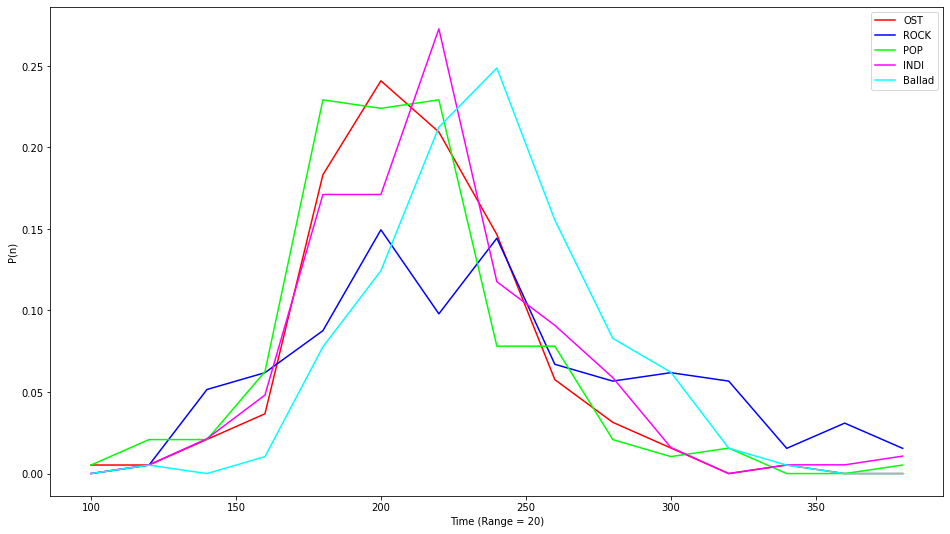

In [ ]:
import pickle
import matplotlib.pyplot as plt
from decimal import Decimal

with open('2021_10_31.pkl', 'rb') as a:
    data_a = pickle.load(a)

# Pickle에 박자 고려한 코드 리스트는 없길래 변조코드 함수에 있던 거 불러와서 다시 만들었음.
def chord_list_with_space(new_chord, space_num):
      chord_list_with_space = []
      for i in range(len(new_chord)):
        n = int(space_num[i])
        for j in range(n):
          chord_list_with_space.append(new_chord[i])
      return chord_list_with_space

# 노래 길이 리스트 만드는 함수
def playtime_of_songs(n):
  P = []

  # data_a의 원소 하나하나(곡 하나하나)마다 플레이타임 계산해서 P에 저장함.
  for A in data_a:
    new_chord = A.get('New_chord')
    space_num = A.get('Space_num')
    space_chord = chord_list_with_space(new_chord, space_num)
    # print(space_chord)

    chord_length = len(space_chord)
    bpm = Decimal(A.get('BPM'))
    playtime = float(chord_length * 60 / bpm)
    # print(chord_length)
    # print(space_num)
    # print(playtime)
    P.append(playtime)

  return P

# Data는 곡들의 플레이타임을 모아둔 리스트이다(숫자 형태는 Decimal이 아니라 float으로 했음).
Data = playtime_of_songs(data_a)
# print(Data)
# print(len(data_a))
# print(len(playtime_of_songs(data_a)))



##### 전체 길이 분포 분석

# I_max는 x축 최대 길이이다.
# Range는 몇 초 범위로 곡들을 셀 것인지 정해준다.
# 예를 들어 I_max가 500이면 500초까지 보고, 그때 Range가 10이면 10초 단위로 끊어서 그래프에 나타낸다.
# 100초 이하의 곡은 고려하지 않는다.
l_max = 400
Range = 20
n_songs = len(Data)
cn = 0
for i in range(100//Range,l_max//Range):
  an = 0
  for j in range(n_songs):
    if (i)*Range < Data[j] < (i+1)*Range:
      an += 1
      cn += 1
  plt.scatter(i*Range, an/n_songs, c = '#FF0000')
  plt.scatter(i*Range, cn/n_songs, c = '#0000FF')

plt.legend(('poisson dis','cumulative dis'))
xLabel = "Time. (Range = " + str(Range) + ')'
plt.xlabel(xLabel)
plt.ylabel("P(n)")


##### 종류별 분석
G = ['ost','록/메탈','발라드','pop','인디음악']
l_max = 700
Range = 20
n_songs=len(Data)
a=0
b=0
c=0
d=0
e=0
for i in data_a:
  if i['Genre'] == G[0]:
    a += 1
  elif i['Genre'] == G[1]:
    b += 1
  elif i['Genre'] == G[3]:
    c += 1
  elif i['Genre'] == G[4]:
    d += 1
  elif i['Genre'] == G[2]:
    e += 1

plt.figure(figsize=(16,9))
x = []
y1 = []
y2 = []
y3 = []
y4 = []
y5 = []
for i in range(100//Range,l_max//Range):
  an = 0
  bn = 0
  cn = 0
  dn = 0
  en = 0
  for j in range(n_songs):
    if (i)*Range < Data[j] < (i+1)*Range:
      if data_a[j]['Genre'] == G[0]:
        an += 1
      elif data_a[j]['Genre'] == G[1]:
        bn += 1
      elif data_a[j]['Genre'] == G[3]:
        cn += 1
      elif data_a[j]['Genre'] == G[4]:
        dn += 1
      elif data_a[j]['Genre'] == G[2]:
        en += 1
  x.append(i*Range)
  y1.append(an/a)
  y2.append(bn/b)
  y3.append(cn/c)
  y4.append(dn/d)
  y5.append(en/e)


plt.plot(x,y1,c = '#FF0000')
plt.plot(x,y2,c = '#0000FF')
plt.plot(x,y3,c = '#00FF00')
plt.plot(x,y4,c = '#FF00FF')
plt.plot(x,y5,c = '#00FFFF')

plt.legend(('OST','ROCK', 'POP', 'INDI','Ballad'))
xLabel = "Time (Range = " + str(Range) + ')'
plt.xlabel(xLabel)
plt.ylabel("P(n)")

In [ ]:
for i in data_a:
  if i['WhoUploaded'] == 'kstphysics':
    print(i['BPM'], i['Songname'], i['Genre'], i['Date'], sep = ' / ')

Text(0, 0.5, 'P(n)')

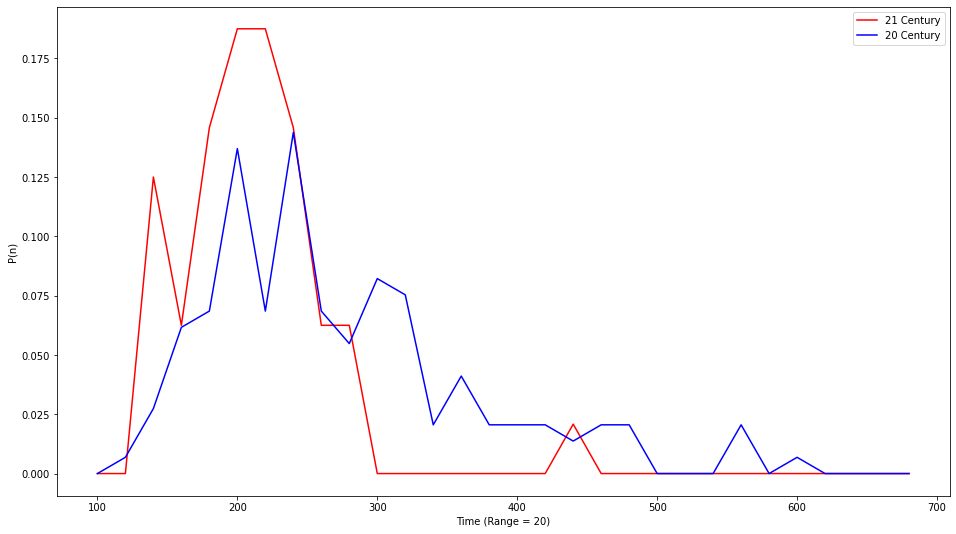

In [ ]:
# 락/메탈 시대별 분석
G = ['ost','록/메탈','발라드','pop','인디음악']
Y = 2000
l_max = 700
Range = 20
a=0
b=0
for i in data_a:
  if i['Genre'] == G[1]:
    if int(i['Date'][0:4]) >= Y:
      a += 1
    else:
      b += 1

plt.figure(figsize=(16,9))
x = []
y1 = []
y2 = []
for i in range(100//Range,l_max//Range):
  an = 0
  bn = 0
  for j in range(n_songs):
    if (i)*Range < Data[j] < (i+1)*Range:
      if data_a[j]['Genre'] == G[1] and int(data_a[j]['Date'][0:4]) >= Y :
        an += 1
      elif data_a[j]['Genre'] == G[1] and int(data_a[j]['Date'][0:4]) < Y:
        bn += 1
  x.append(i*Range)
  y1.append(an/a)
  y2.append(bn/b)

plt.plot(x,y1,c = '#FF0000')
plt.plot(x,y2,c = '#0000FF')

plt.legend(('21 Century','20 Century'))
xLabel = "Time (Range = " + str(Range) + ')'
plt.xlabel(xLabel)
plt.ylabel("P(n)")

Text(0, 0.5, 'P(n)')

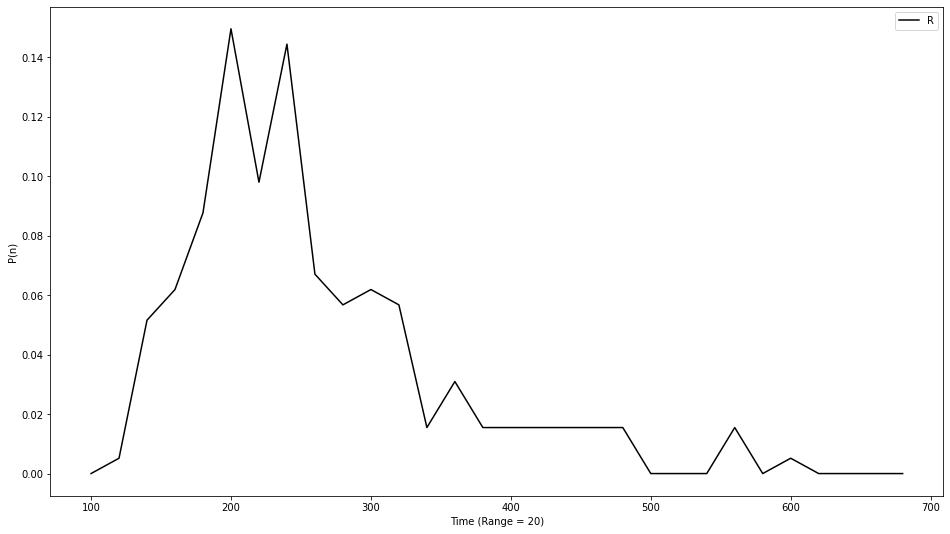

In [ ]:
# 락/메탈 시대별 분석
G = ['ost','록/메탈','발라드','pop','인디음악']
Y = 2000
l_max = 700
Range = 20
a=0
for i in data_a:
  if i['Genre'] == G[1]:
    a += 1


plt.figure(figsize=(16,9))
x = []
y1 = []
for i in range(100//Range,l_max//Range):
  an = 0
  for j in range(n_songs):
    if (i)*Range < Data[j] < (i+1)*Range:
      if data_a[j]['Genre'] == G[1]:
        an += 1
  x.append(i*Range)
  y1.append(an/a)

plt.plot(x,y1,c = '#000000')

plt.legend(('Rock/Metal'))
xLabel = "Time (Range = " + str(Range) + ')'
plt.xlabel(xLabel)
plt.ylabel("P(n)")

Text(0, 0.5, 'P(n)')

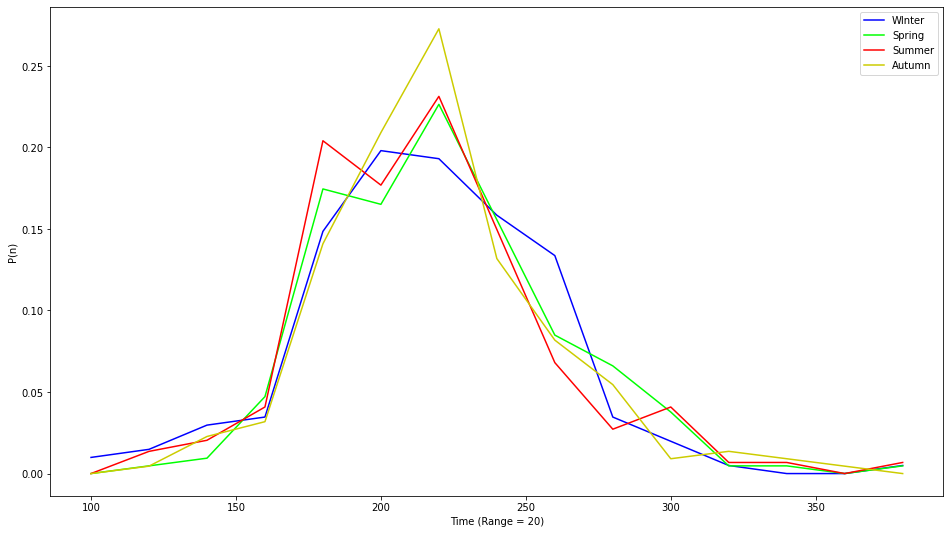

In [ ]:
# 계절별 분석
G = '록/메탈'
season = ['spring', 'summer', 'autumn', 'winter']
l_max = 400
Range = 20
a=0
b=0
c=0
d=0
for i in data_a:
  if i['Date'] == '':
    continue
  if i['Genre'] != G:
    if int(i['Date'][-2:]) == 12 or 1 <= int(i['Date'][-2:]) <= 2:
      a += 1
    if 3 <= int(i['Date'][-2:]) <= 5:
      b += 1
    if 6 <= int(i['Date'][-2:]) <= 8:
      c += 1
    if 9 <= int(i['Date'][-2:]) <= 11:
      d += 1

plt.figure(figsize=(16,9))
x = []
y1 = []
y2 = []
y3 = []
y4 = []

for i in range(100//Range,l_max//Range):
  an = 0
  bn = 0
  cn = 0
  dn = 0
  for j in range(n_songs):
    if data_a[j]['Date'] == '':
      continue
    if (i)*Range < Data[j] < (i+1)*Range:
      if data_a[j]['Genre'] != G:
        if int(data_a[j]['Date'][-2:]) == 12 or 1 <= int(data_a[j]['Date'][-2:]) <= 2:
          an += 1
        if 3 <= int(data_a[j]['Date'][-2:]) <= 5:
          bn += 1
        if 6 <= int(data_a[j]['Date'][-2:]) <= 8:
          cn += 1
        if 9 <= int(data_a[j]['Date'][-2:]) <= 11:
          dn += 1
  x.append(i*Range)
  y1.append(an/a)
  y2.append(bn/b)
  y3.append(cn/c)
  y4.append(dn/d)

plt.plot(x,y1,c = '#0000FF')
plt.plot(x,y2,c = '#00FF00')
plt.plot(x,y3,c = '#FF0000')
plt.plot(x,y4,c = '#CCCC00')

plt.legend(('WInter','Spring','Summer','Autumn'))
xLabel = "Time (Range = " + str(Range) + ')'
plt.xlabel(xLabel)
plt.ylabel("P(n)")

# # 빌리 아일리시 빌리 에일리쉬 빌리 아일리쉬 billie eilish

In [ ]:
import json
with open('./train.json', 'rb') as f:
    pl = json.load(f)
  
print(pl[0])

#  'songs': [525514, 129701, 38   /   'tags': ['락']

{'tags': ['락'], 'id': 61281, 'plylst_title': '여행같은 음악', 'songs': [525514, 129701, 383374, 562083, 297861, 139541, 351214, 650298, 531057, 205238, 706183, 127099, 660493, 461973, 121455, 72552, 223955, 324992, 50104], 'like_cnt': 71, 'updt_date': '2013-12-19 18:36:19.000'}


In [ ]:
with open('./song_meta.json', 'rb') as f:
    num = json.load(f)

print(num[10])

#  'id': 10   / 'song_name': 'Hi (Heyoo)'

{'song_gn_dtl_gnr_basket': ['GN1201'], 'issue_date': '20170407', 'album_name': 'Luv.Loops', 'album_id': 10053652, 'artist_id_basket': [1625859], 'song_name': 'Hi (Heyoo)', 'song_gn_gnr_basket': ['GN1200'], 'artist_name_basket': ['Miraa.'], 'id': 10}


In [ ]:
import pickle as pkl
with open('./2021_10_31.pkl', 'rb') as f:
  s = pkl.load(f)

print(s[5])

#  'Songname': 'Breaking Down',

{'Date': '2010-01', 'WhoUploaded': 'kstphysics', 'Original_keynote': 'D#', 'New_chord': ['G#', 'D#', 'D', 'Fm', 'A#', 'Fm', 'G#', 'Gm', 'Cm', 'Fm', 'A#', 'D#', 'G#', 'D#', 'G#', 'Gm', 'G#', 'A#', 'Dm', 'C', 'F', 'G', 'E', 'C', 'Dm', 'G', 'F', 'C', 'F', 'G', 'E', 'Am', 'G', 'F', 'Em', 'Dm', 'G', 'Cm', 'Fm', 'A#', 'G#', 'Gm', 'Cm', 'G#', 'A#', 'D#', 'G#', 'Gm', 'Fm', 'D#', 'G#', 'D#', 'G#', 'A#m', 'Fm', 'Dm', 'C', 'F', 'G', 'E', 'C', 'F', 'Em', 'Dm', 'G', 'C', 'F', 'G', 'Em', 'G', 'F', 'Dm', 'G', 'C', 'F', 'C', 'F', 'Am', 'F', 'Am', 'G#', 'Gm', 'C', 'F', 'G', 'E', 'C', 'F', 'C', 'Dm', 'C', 'F', 'G', 'E', 'C', 'F', 'C', 'G', 'C', 'F', 'C', 'B', 'Dm', 'G'], 'Country': 'kr', 'Artist': '포맨', 'Chord_rates_with_space': {'A#': Decimal('0.04086021505376344'), 'B': Decimal('0.008602150537634409'), 'C': Decimal('0.14623655913978495'), 'D': Decimal('0.0064516129032258064'), 'E': Decimal('0.047311827956989246'), 'Gm': Decimal('0.060215053763440864'), 'F': Decimal('0.11612903225806452'), 'Fm': Decima

In [ ]:
from tqdm import tqdm

for i in tqdm(range(len(s))):
  for j in range(len(num)):
    if s[i]['Songname'] == num[j]['song_name'] and s[i]['Date'][:-3]+s[i]['Date'][-2:] == num[j]['issue_date'][:-2]:
      s[i]['id'] = num[j]['id']
      s[i]['id_artist'] = num[j]['artist_name_basket']
      s[i]['id_date'] = num[j]['issue_date'][:-2] 
      break
  else :
    s[i]['id'] = 'none'

print(s[10])

100%|██████████| 977/977 [03:25<00:00,  4.75it/s]

{'Date': '2003-09', 'WhoUploaded': 'sunggulee2', 'Original_keynote': 'F', 'New_chord': ['F', 'Gm', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'A#', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'C', 'Dm', 'C', 'A#', 'F', 'C', 'A#', 'C', 'A#', 'Am', 'Gm', 'Am', 'A#', 'C', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'C', 'F', 'A#', 'F', 'C', 'F', 'C', 'Dm', 'F', 'A#', 'F', 'C', 'A#', 'C', 'A#', 'Am', 'Gm', 'Am', 'A#', 'C', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'C', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'C', 'F', 'C', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'A#'], 'Country': 'kr', 'Artist': '체리필터', 'Chord_rates_with_space': {'Dm': Decimal('0.11716171617161716'), 'A#': Decimal('0.14686468646864687'), 'C': Decimal('0.297029702970297'), 'Am': Decimal('0.033003300330033'), 'F': Decimal('0.3844884488448845'), 'Gm': Decimal('0.02145

In [ ]:
for i in tqdm(range(len(s))):
  for j in range(len(pl)):
    try:
      if s[i]['id'] in pl[j]['songs']:
        s[i]['tags'] = pl[j]['tags']
        break
    except:
      pass

print(s[100],'\n', s[101], '\n', s[102])

100%|██████████| 977/977 [00:54<00:00, 18.08it/s]

{'Date': '2009-02', 'WhoUploaded': 'sunggulee2', 'Original_keynote': 'A#', 'New_chord': ['C', 'G', 'A#', 'Am', 'F', 'D', 'G', 'Am', 'Dm', 'C', 'G', 'A#', 'F', 'Em', 'Am', 'F', 'D', 'F', 'D', 'E', 'G', 'Am', 'F', 'Em', 'Am', 'F', 'G', 'C', 'Em', 'C', 'Am', 'G', 'F', 'Em', 'C', 'Dm', 'F', 'G', 'C', 'G', 'Am', 'C', 'G', 'F', 'D', 'C', 'Dm', 'Em', 'Am', 'G', 'Am', 'G', 'F', 'C', 'Em', 'G', 'Am', 'G', 'F', 'Em', 'C', 'Dm', 'F', 'G', 'F', 'C', 'G', 'D', 'Am', 'C', 'G', 'F', 'D', 'C', 'Dm', 'Em', 'Am', 'G', 'Am', 'G', 'F', 'Dm', 'F', 'G'], 'Country': 'kr', 'Artist': '에피톤프로젝트', 'Chord_rates_with_space': {'A#': Decimal('0.02099236641221374'), 'C': Decimal('0.17748091603053434'), 'D': Decimal('0.03625954198473282'), 'E': Decimal('0.015267175572519083'), 'F': Decimal('0.21183206106870228'), 'G': Decimal('0.24618320610687022'), 'Em': Decimal('0.07442748091603053'), 'Dm': Decimal('0.06870229007633588'), 'Am': Decimal('0.14885496183206107')}, 'Space_num': [Decimal('10'), Decimal('12'), Decimal('4'),

In [ ]:
c=0
for i in s:
  if i['id'] != 'none':
    c += 1
print(c)

670


In [ ]:
dic_tags = {}
for i in range(len(s)):
  try:
    for j in s[i]['tags']:
      dic_tags[j] = dic_tags.get(j,0) + 1
  except:
    pass

tags = sorted(dic_tags.items(), key=lambda x:x[1], reverse=True)
print(tags)

[('감성', 96), ('발라드', 90), ('힐링', 89), ('휴식', 86), ('사랑', 81), ('기분전환', 80), ('새벽', 70), ('잔잔한', 69), ('밤', 65), ('이별', 56), ('드라이브', 54), ('추억', 53), ('슬픔', 49), ('인디', 46), ('설렘', 42), ('회상', 38), ('팝', 35), ('Pop', 34), ('비오는날', 30), ('여행', 26), ('카페', 25), ('OST', 24), ('가을', 23), ('스트레스', 23), ('겨울', 21), ('신나는', 20), ('봄', 20), ('락', 18), ('우울', 18), ('명곡', 17), ('알앤비', 17), ('산책', 16), ('매장음악', 15), ('조용한', 15), ('드라마', 14), ('까페', 14), ('혼자', 14), ('댄스', 12), ('운동', 12), ('새벽감성', 12), ('주말', 12), ('감미로운', 12), ('위로', 12), ('달달', 12), ('힙합', 11), ('분위기', 11), ('여름밤', 10), ('취향저격', 10), ('감성발라드', 10), ('Rock', 10), ('팝송', 10), ('록', 9), ('어쿠스틱', 9), ('고백', 8), ('저녁', 8), ('혼자있을때', 8), ('좋은노래', 8), ('매장', 8), ('나만알고싶은', 8), ('80년대', 7), ('여름', 7), ('영화', 7), ('조용히', 7), ('또는', 7), ('고민', 7), ('맥주한잔', 7), ('추천곡', 7), ('재즈', 7), ('연말', 7), ('커피', 7), ('빌보드', 7), ('여자가수', 7), ('90년대', 6), ('비', 6), ('가요', 6), ('썸', 6), ('달달한', 6), ('질리지않는', 6), ('명품발라드', 6), ('고음병', 6), ('편안한', 6), ('

In [ ]:
------------------------------------

In [ ]:
# 곡명 일치시키기
# ==을 in으로 바꾸었으므로 정확도가 부족해질 것이 뻔하기 때문에, 초기에 만든 코드를 돌린 뒤 id가 none인 경우에 대해서만 수행해준다.
# 소문자 변환 : .lower() - 한국어나 특수문자 포함되어도 문제없이 잘 작동함
# 공백 지우기 : .replace(" ","")
# '를 `로 변환 : replace("'","`")
# 피아니시모나 We Don't Talk Anymore처럼 뒤에 부제나 피처링한 인물이 괄호로 붙는 경우 -> ==이 아니라 in으로 쓰자...
# 이름이 같은 곡이 워낙 많다보니 아티스트를 대조해야 할 필요가 있다.
from tqdm import tqdm

for i in tqdm(range(len(s))):
  if s[i]['id'] == 'none':
    for j in range(len(num)):
      Sn = s[i]['Songname'].replace(" ","").replace("'","`")
      sn = num[j]['song_name'].replace(" ","")
      if Sn.lower() in sn.lower() and s[i]['Date'][:-3]+s[i]['Date'][-2:] == num[j]['issue_date'][:-2]:
        s[i]['id'] = num[j]['id']
        s[i]['id_artist'] = num[j]['artist_name_basket']
        s[i]['id_date'] = num[j]['issue_date'][:-2]
        break
print(s[10])

100%|██████████| 977/977 [06:06<00:00,  2.67it/s]

{'Date': '2003-09', 'WhoUploaded': 'sunggulee2', 'Original_keynote': 'F', 'New_chord': ['F', 'Gm', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'A#', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'C', 'Dm', 'C', 'A#', 'F', 'C', 'A#', 'C', 'A#', 'Am', 'Gm', 'Am', 'A#', 'C', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'C', 'F', 'A#', 'F', 'C', 'F', 'C', 'Dm', 'F', 'A#', 'F', 'C', 'A#', 'C', 'A#', 'Am', 'Gm', 'Am', 'A#', 'C', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'C', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'C', 'F', 'C', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'Dm', 'C', 'A#', 'F', 'C', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'A#', 'F', 'C', 'Dm', 'A#'], 'Country': 'kr', 'Artist': '체리필터', 'Chord_rates_with_space': {'Dm': Decimal('0.11716171617161716'), 'A#': Decimal('0.14686468646864687'), 'C': Decimal('0.297029702970297'), 'Am': Decimal('0.033003300330033'), 'F': Decimal('0.3844884488448845'), 'Gm': Decimal('0.02145

In [ ]:
# 곡명만 같은 다른 노래가 뽑아졌는지 확인하기 위해, id_artsit와 Artist를 비교해보자
for i in s:
  if i['id'] != 'none':
    print(i['WhoUploaded'],i['Songname'],i['Artist'],i['id_artist'],i['Date'],i['id_date'], sep = ' / ')


sunggulee2 / 거짓말 같은 시간 / 토이 / ['김연우'] / 1999-01 / 199901
kstphysics / 세 사람 / 토이 / ['토이'] / 2014-11 / 201411
sunggulee2 / 여전히 아름다운지 / 토이 / ['김연우'] / 2001-11 / 200111
sunggulee2 / 해줄 수 없는 일 / 토이 / ['거미'] / 2015-04 / 201504
kstphysics / 못해 / 포맨 / ['포맨'] / 2010-01 / 201001
sunggulee2 / Happy Day / 체리필터 / ['체리 필터'] / 2006-08 / 200608
kstphysics / 낭만고양이 / 체리필터 / ['체리 필터'] / 2002-08 / 200208
kstphysics / 달빛소년 / 체리필터 / ['체리 필터'] / 2003-09 / 200309
sunggulee2 / 오리 날다 / 체리필터 / ['체리 필터'] / 2003-09 / 200309
sunggulee2 / 피아니시모 / 체리필터 / ['체리 필터'] / 2009-08 / 200908
sunggulee2 / 별 빛이 내린다 / 안녕바다 / ['안녕바다'] / 2009-12 / 200912
sunggulee2 / I Believe / 이수영 / ['이수영'] / 1999-11 / 199911
dlgjstlr7191 / 너만 너만 너만 / 양다일 / ['양다일'] / 2019-07 / 201907
dlgjstlr7191 / 그대만 보여서 / 김나영 / ['김나영'] / 2018-06 / 201806
dlgjstlr7191 / 조금 더 외로워지겠지 / 김나영 / ['김나영'] / 2019-07 / 201907
johnbyun98 / Uptown Funk / Mark Ronson / ['Mark Ronson'] / 2014-11 / 201411
dlgjstlr7191 / My Heart Will Go On / Celine Dion / ['Celine Dion'] / 1

In [ ]:
# 도비 지수 : 몇 개의 노래가 무욤지물이 되었는지를 나타내는 지표이다.
def Dobby(name):
  c = 0
  for i in s:
    if i['id'] == 'none' and i['WhoUploaded'] == name:
      c += 1
  print(c)

Dobby('sunggulee2')
Dobby('johnbyun98')
Dobby('kstphysics')
Dobby('dlgjstlr7191')

# 쓸모가 없어진 노래를 뽑아보자
for i in s:
  if i['id'] == 'none':
    print(i['WhoUploaded'],i['Songname'],i['Artist'],sep = ' / ')

# Pick Up Your Feelings - 없음
# Mystery Lady - 없음
# 아직 너의 시간에 살아 - 없음
# 비의 Rhapsody - 비의 랩소디 / 113667
# | Let Her Go - 없음
# Future Kids - 없음
# Remember That Night? - 없음
# 드레스코드 - Dress Code (Feat. G2) / 691849
# telepatia - 없음
# Glistening - 없음
# Gucci Sweater - 없음
# 그렇게 넌 내게 빛나 - 없음
# drivers license - 없음
# A Step You Can't Take Back - A Step You Can’t Take Back / 544743
# Speechless (Full) (From "Aladdin"/Soundtrack Version) - / 54952
# 봄처럼 내게 와 - 봄처럼 내게와 / 66751
# Lost Starts - Lost Stars / 155336
# Flame Twin - 없음
# Shallow (from A Star Is Born) - 없음
# la di die - 없음
# 널 사랑했던 한 사람 - 없음
# Thank God It's Christmas - Thank God It&#39;s Christmas (Non-Album Single) / 70602
# Minefields - 없음
# U Move, I Move - 없음
# 나의 오월 - 없음
# Better When I'm Dancing - Better When I`m Dancin` / 279229
# Fire In The Water - 없음
# How Fall I'll Go - 없음
# 넌 친구? 난 연인! - 넌 친구 난 연인! / 15722
# 밤하늘의 저 별처 - 없음
# 밤하늘의 저 별처럼 - 없음
# 내새랑 내곁에 - 내 사랑 내 곁에 /  281411
# 오키도키야 - 없음
# Leave the Door Open - 없음
# That’s What I Like - That`s What I Like / 219225
# Nobody's Love - 없음
# 소란한 밤을 지나 - 없음
# 작전명 청-춘! - 없음
# Levitating Featuring DaBaby - Levitating / 92425
# 붉은 꽃그늘 아래서 - 없음
# 이게 바로 나야 - 없음
# 힘든 건 사랑이 아니다 - 없음

27
99
124
57
dlgjstlr7191 / Breaking Down / 에일리(Ailee)
kstphysics / 살다가 한번쯤 / 포맨
dlgjstlr7191 / I See the Light / Mandy Moore, Zachary Levi
dlgjstlr7191 / 낙화 (落花) / 양다일
johnbyun98 / Lush Life / Zara Larsson
johnbyun98 / Pick Up Your Feelings / Jazmine Sullivan
kstphysics / Break Stuff / 림프비즈킷
kstphysics / Faith / 림프비즈킷
kstphysics / Nookie / 림프비즈킷
kstphysics / Rusty Nail / 엑스재팬
johnbyun98 / I'm The One / DJ Khaled
kstphysics / Animals / 니켈백
kstphysics / Far Away / 니켈백
kstphysics / How You Remind Me / 니켈백
kstphysics / Rockstar / 니켈백
kstphysics / Savin' Me / 니켈백
johnbyun98 / Mystery Lady / Masego
sunggulee2 / 싸구려 커피 / 장기하와 얼굴들
johnbyun98 / 아직 너의 시간에 살아 / 이수현
sunggulee2 / 비의 Rhapsody / 최재훈
sunggulee2 / 외출 / 최재훈
johnbyun98 / Lilac / Fthmlss
johnbyun98 / | Let Her Go / Passenger
johnbyun98 / 그게 나야 / 박원
dlgjstlr7191 / 운명의 시간 / 윤도현
kstphysics / In God We Trust / 스트라이퍼
kstphysics / The Way / 스트라이퍼
kstphysics / To Hell With The Devil / 스트라이퍼
kstphysics / 18 And Life / 스키드로
kstphysics / I Remembe

In [ ]:
# 없는 놈들 수동으로 찾아보는 코드
for i in range(len(num)):
  if 'Bruno Mars' in num[i]['artist_name_basket']:
    #if 'Leave' in num[i]['song_name']:
      print(num[i]['song_name'],num[i]['id'])

In [ ]:
# 0. none 갯수 많이 줄였음(고생했으), none 아닌 것들 중 artists 다른 갯수 몇개?
# 1. 기존의 아티스트와 일치하는 노래 따로 빼서 저장 ( = 일치하지 않거나 없는 노래 목록 생성, 예시로 none_artists list)
# 2. none_artists에 들어있는 노래들의 아티스트 리스트 출력
# 3. 멜론 데이터에 검색해서 가수 수정하는 코드 생성 (dict로 만들어서 edit_artist = {input_artist : melon_artist} ) 생각중
# 4. 변경 후 노래제목과 아티스트 모두 일치하는 경우로 수정(승태 완료)

In [ ]:
data = []
for a in s:
  try:
    data.append({'Original_keynote':a['Original_keynote'],'Songname':a['Songname'],'tags':a['tags']})
  except:
    pass

In [ ]:
for a in data:
  print(a)
len(data)

{'Original_keynote': 'D', 'Songname': '거짓말 같은 시간', 'tags': ['80년대', '감성', '90년대발라드', '올드송', '추억', '휴식', '90년대', '옛날노래']}
{'Original_keynote': 'F', 'Songname': '세 사람', 'tags': ['비오는날', '비_오는_날', '휴식', '비_오는날', '비']}
{'Original_keynote': 'C', 'Songname': '여전히 아름다운지', 'tags': ['힐링', '휴식', '밤', '새벽']}
{'Original_keynote': 'Cm', 'Songname': '해줄 수 없는 일', 'tags': ['발라드']}
{'Original_keynote': 'D#', 'Songname': '못해', 'tags': ['힐링', '휴식', '가을']}
{'Original_keynote': 'Gm', 'Songname': 'Happy Day', 'tags': ['잔잔한', '밤', '새벽']}
{'Original_keynote': 'A#', 'Songname': '낭만고양이', 'tags': ['우울할때', '추억회상', '운동할때', '신날때', '2000', '2000년대', 'Top100에', '댄스신에', '댄스음악', '기쁠때']}
{'Original_keynote': 'A', 'Songname': '달빛소년', 'tags': ['발라드']}
{'Original_keynote': 'F', 'Songname': '오리 날다', 'tags': ['스트레스', '기분전환']}
{'Original_keynote': 'G#', 'Songname': '피아니시모', 'tags': ['댄스']}
{'Original_keynote': 'B', 'Songname': '별 빛이 내린다', 'tags': ['여름', '운동']}
{'Original_keynote': 'B', 'Songname': 'I Believe', 'tags': ['한번쯤들어

661

In [ ]:
import pickle
 
## Save pickle
with open("2021_11_14_tagged.pkl","wb") as f:
    pickle.dump(data,f)